# DAY-AHEAD LOAD FORECASTING USING STATISTICAL MODELS




---





# Importing Libraries

Necessary Installations


In [1]:
%%capture
!pip install arch
!pip install statsmodels

Necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# Importing Data

In [ ]:
!gdown 1nhyP5KkTsu-TqgNjlY_fGt6Y3loFj_b3
data = pd.read_csv('/content/full-year-load-data.csv')

Downloading...
From: https://drive.google.com/uc?id=1nhyP5KkTsu-TqgNjlY_fGt6Y3loFj_b3
To: /content/full-year-load-data.csv
100% 1.06M/1.06M [00:00<00:00, 95.2MB/s]


Setting Date column as index for our data.

In [ ]:
data['date_column'] = pd.to_datetime(data['date_column'], format='%Y-%m-%d %H:%M:%S')
# Setting the 'date_column' as the index
data.set_index('date_column', inplace=True)
data.head()

,value
date_column,
2022-04-01 00:00:00,51.78
2022-04-01 00:15:00,46.16
2022-04-01 00:30:00,42.42
2022-04-01 00:45:00,44.33
2022-04-01 01:00:00,49.67


# Train Test Split

In [ ]:
print(data.shape)
train=data.iloc[:-2880]
test=data.iloc[-2880:]
print(train.shape,test.shape)

(37920, 1)
(35040, 1) (2880, 1)


# Defining Required Functions And Models

 ARIMA MODEL from statsmodel library



In [ ]:
def arima_model(train,test,p,d,q,freq):
  model=sm.tsa.arima.ARIMA(train,order=(p,d,q),freq=freq)
  model_fit=model.fit(cov_type='oim')
  print(model_fit.summary())
  forecast=model_fit.get_forecast(steps=len(test))
  return forecast.predicted_mean, model_fit.resid

GARCH MODEL

In [ ]:
def garch_on_resid(resid,p,q):
  model=arch_model(resid,p=p,q=q)
  model_fit=model.fit()
  print(model_fit.summary())
  garch_forecast=model_fit.forecast(horizon=2880)
  garch_forecast_variance=garch_forecast.variance.values[-1,:]
  return garch_forecast_variance

SARIMAX MODEL

In [ ]:
def sarima_model(train,test,p,d,q,P,D,Q,m,freq):
  order=(p,d,q)
  seasonal_order=(P,D,Q,m)
  model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order)
  model_fit=model.fit()
  print(model_fit.summary())
  forecast=model_fit.get_forecast(steps=len(test))
  return forecast.predicted_mean, model_fit.resid

Defining a function to plot test time series data and forecasted values togetther.

In [ ]:
def plot_forecast(test,forecast):
  plt.figure(figsize=(10, 6))

  plt.plot(test.index, test['value'], label='Original Values')
  plt.plot(forecast.index, forecast['forecast'], label='Forecast Values')

  plt.xlabel('Date')
  plt.ylabel('Value')
  plt.title('original and forecasted Time Series')
  plt.legend()
   # Show legend based on 'label' values

  # Display the plot
  plt.grid(True)  # Optional: add grid
  plt.tight_layout()  # Optional: improve spacing
  plt.show()



------



# ARIMA

Now starting with ARIMA as foreacast model. Here we are directly inputing the complete training data into the model for future predictions.


In [ ]:
forecast, resid = arima_model(train,test,3,1,3,'15T')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                35040
Model:                 ARIMA(3, 1, 3)   Log Likelihood             -109210.646
Date:                Wed, 26 Jun 2024   AIC                         218435.293
Time:                        16:09:44   BIC                         218494.542
Sample:                    04-01-2022   HQIC                        218454.164
                         - 03-31-2023                                         
Covariance Type:                  oim                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0810      0.055      1.485      0.138      -0.026       0.188
ar.L2          0.9117      0.050     18.306      0.000       0.814       1.009
ar.L3         -0.1204      0.017     -7.036      0.0



> We can see here the results for the ARIMA model on the training data. The diagonstic test in the last of model summary suggests:
*   Ljung-Box : suggests that there is no significant autocorrelation in the residuals.
*   Heteroskedasticity : suggesting no significant heteroskedasticity in the residuals.
*   JB : suggests residuals are not normal
*   skew : slight skewness in residual distribution
*   Kurtosis: suggests slight leptokurtic distribution (heavy tails), suspected outliers









In [ ]:
forecast = pd.DataFrame(forecast,index=test.index)
forecast.columns=['forecast']
forecast

,forecast
date_column,
2023-04-01 00:00:00,62.387820
2023-04-01 00:15:00,62.361264
2023-04-01 00:30:00,62.279403
2023-04-01 00:45:00,62.208669
2023-04-01 01:00:00,62.131504
...,...
2023-04-30 22:45:00,61.243118
2023-04-30 23:00:00,61.243118
2023-04-30 23:15:00,61.243118



> Plotting Forecasted Values vs Original data for 2 DAYS



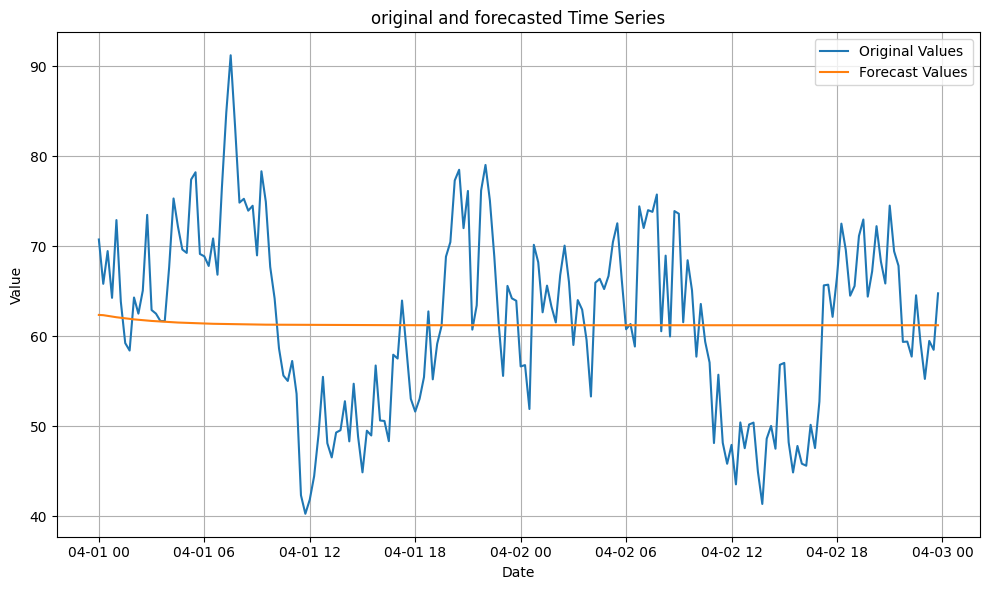

In [ ]:
plot_forecast(test.iloc[:192],forecast.iloc[:192])



> We can look here that training ARIMA directly on the training data could not perform well. It was not able to extrapolate the seasonality and local variations from the training data into the future predictions.



In [ ]:
resid = pd.DataFrame(resid,index=train.index)
resid.columns=['resid']
resid.head()

,resid
date_column,
2022-04-01 00:00:00,51.780000
2022-04-01 00:15:00,-5.619486
2022-04-01 00:30:00,-5.349041
2022-04-01 00:45:00,-0.102652
2022-04-01 01:00:00,4.896424


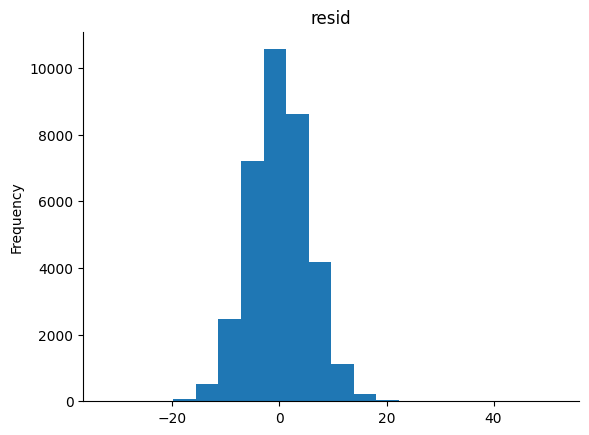

In [ ]:
resid['resid'].plot(kind='hist', bins=20, title='resid')
plt.gca().spines[['top', 'right',]].set_visible(False)

# ARIMA x GARCH



> Trying the GARCH model over Residues obtained from the ARIMA model to capture local variations.



In [ ]:
garch_forecast_variance=garch_on_resid(resid,3,3)

Iteration:      1,   Func. Count:     10,   Neg. LLF: 148978.99746388747
Iteration:      2,   Func. Count:     21,   Neg. LLF: 165014.93204050328
Iteration:      3,   Func. Count:     33,   Neg. LLF: 62218240.41240005
Iteration:      4,   Func. Count:     45,   Neg. LLF: 7705290285.445591
Iteration:      5,   Func. Count:     55,   Neg. LLF: 109223.98346049942
Iteration:      6,   Func. Count:     65,   Neg. LLF: 109260.2466780407
Iteration:      7,   Func. Count:     75,   Neg. LLF: 109208.19601524645
Iteration:      8,   Func. Count:     84,   Neg. LLF: 109207.89073501743
Iteration:      9,   Func. Count:     93,   Neg. LLF: 109207.88619919309
Iteration:     10,   Func. Count:    103,   Neg. LLF: 109207.87025128072
Iteration:     11,   Func. Count:    112,   Neg. LLF: 109207.87021872762
Iteration:     12,   Func. Count:    121,   Neg. LLF: 109207.8702261077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 109207.87021872774
            Iterati

In [ ]:
final_forecast = forecast.forecast + np.sqrt(garch_forecast_variance)*np.random.normal(size=2880)
final_forecast = pd.DataFrame(final_forecast,index=test.index)
final_forecast.columns=['forecast']
final_forecast

,forecast
date_column,
2023-04-01 00:00:00,62.612119
2023-04-01 00:15:00,58.396260
2023-04-01 00:30:00,62.342219
2023-04-01 00:45:00,59.555143
2023-04-01 01:00:00,55.092691
...,...
2023-04-30 22:45:00,54.147726
2023-04-30 23:00:00,65.876863
2023-04-30 23:15:00,59.633197


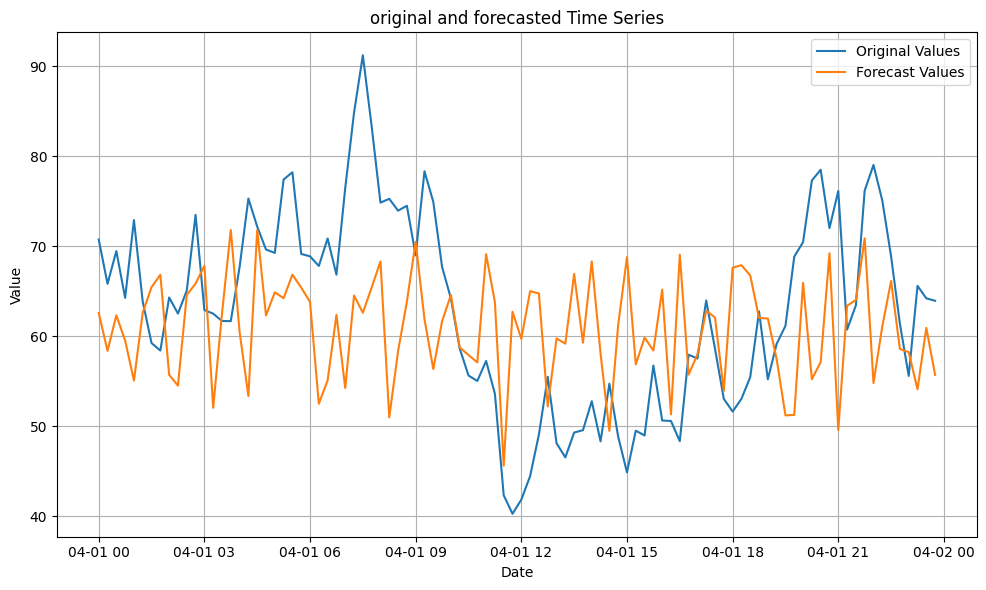

In [ ]:
plot_forecast(test.iloc[:96],final_forecast.iloc[:96])



> Here also we can see that even though model did betetrn on having local variations but still the seasonality is missing. We need to use some other non linear methods that can take care of SEASONALITY explicitly.
  1.  Using Model that consider SEASONALITY EXPLICITY
*   SARIMA MODEL
*   EXPONENTIAL SMOOTHING
  2.   Decomposing Time Series into Components and Process Seasonality explicitly.






# SARIMAX



> Implementing SARIMAX model from statsmodel library on the complete training data.


> Using SEASONAL PERIODS = 48 for SARIMAX as obtained while performing the spectral analysis for training data.





In [ ]:
sforecast, sresid = sarima_model(train,test,1,0,1,1,0,1,48,'15T')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                35040
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 48)   Log Likelihood             -108570.102
Date:                            Sat, 22 Jun 2024   AIC                         217150.205
Time:                                    06:09:28   BIC                         217192.526
Sample:                                04-01-2022   HQIC                        217163.684
                                     - 03-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9918      0.002    515.641      0.000       0.988       0.996
ma.L1         -0.4632      0.004   

In [ ]:
sforecast = pd.DataFrame(sforecast,index=test.index)
sforecast.columns=['forecast']
sforecast

,forecast
date_column,
2023-04-01 00:00:00,60.707376
2023-04-01 00:15:00,60.019588
2023-04-01 00:30:00,60.968764
2023-04-01 00:45:00,60.819723
2023-04-01 01:00:00,60.619455
...,...
2023-04-30 22:45:00,61.578596
2023-04-30 23:00:00,60.425006
2023-04-30 23:15:00,59.785236


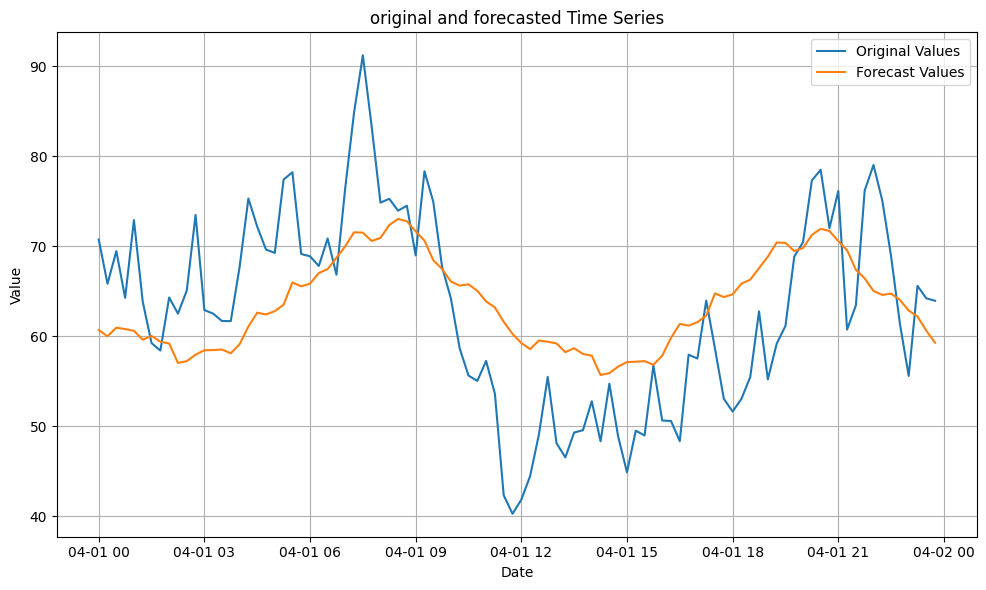

In [ ]:
plot_forecast(test.iloc[:96],sforecast.iloc[:96])



> Here Sarima did perform well for seasonality but not on capturing local variations. We can see in graph that still there is much requirement of improving forecasts.



# SARIMAX x GARCH

> Trying the GARCH model over Residues obtained from the SARIMA model to capture local variations.



In [ ]:
garch_forecast_variance=garch_on_resid(sresid,1,1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 23807938.8559161
Iteration:      2,   Func. Count:     14,   Neg. LLF: 324237.8393136534
Iteration:      3,   Func. Count:     22,   Neg. LLF: 146706.30843172525
Iteration:      4,   Func. Count:     30,   Neg. LLF: 108600.41920316315
Iteration:      5,   Func. Count:     37,   Neg. LLF: 108535.1955770694
Iteration:      6,   Func. Count:     42,   Neg. LLF: 108535.17922172887
Iteration:      7,   Func. Count:     47,   Neg. LLF: 108535.17234987962
Iteration:      8,   Func. Count:     52,   Neg. LLF: 108535.17230978176
Iteration:      9,   Func. Count:     57,   Neg. LLF: 108535.17230796836
Iteration:     10,   Func. Count:     61,   Neg. LLF: 108535.17230796193
Optimization terminated successfully    (Exit mode 0)
            Current function value: 108535.17230796836
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results        

In [ ]:
final_forecast = sforecast.forecast + np.sqrt(garch_forecast_variance)*np.random.normal(size=2880)
final_forecast = pd.DataFrame(final_forecast,index=test.index)
final_forecast.columns=['forecast']
final_forecast

,forecast
date_column,
2023-04-01 00:00:00,57.354928
2023-04-01 00:15:00,64.236235
2023-04-01 00:30:00,64.908780
2023-04-01 00:45:00,66.119331
2023-04-01 01:00:00,56.421901
...,...
2023-04-30 22:45:00,58.478614
2023-04-30 23:00:00,63.837834
2023-04-30 23:15:00,56.881316


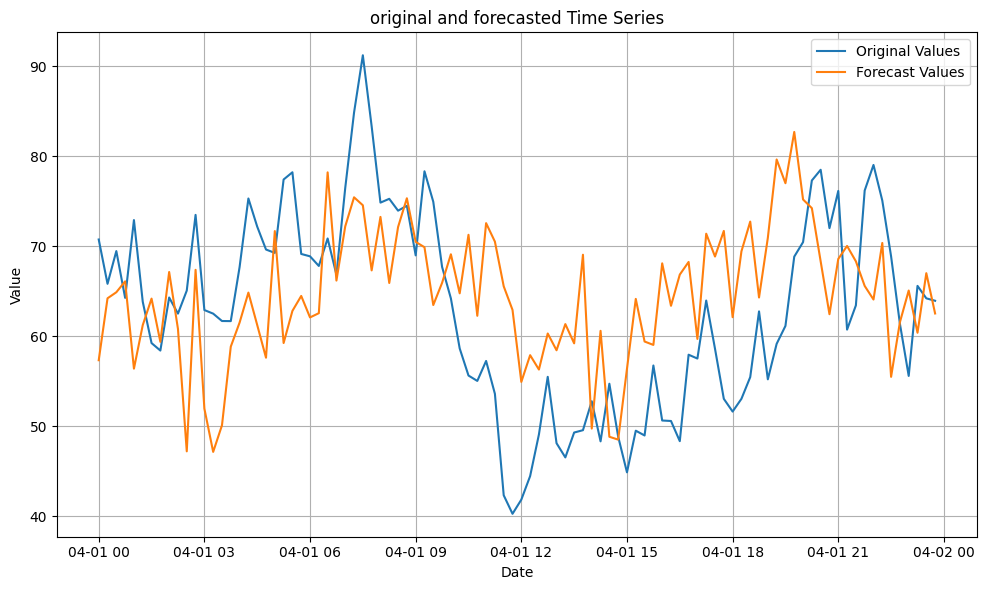

In [ ]:
plot_forecast(test.iloc[:96],final_forecast.iloc[:96])



> Well these predictions were quite decent as they have followed the seasonality values well and also well captured variations as well.



In [ ]:
mape = np.mean(np.abs((test.value - final_forecast.forecast) / test.value)) * 100
mape

13.23705177529488

# Decomposition and Forecasting



> Now using the Decomposition and Processing approach for forecasting our time series values. Forecasting using this method involves:
  1.   Decomposition of TS into:
*   TREND
*   SEASONALITY
*   RESIDUES
  2.   De - Seasoning the TS Data
  3.   Model Selection and Training for De - Seasoned training data
  4.   Obtaining Appropriate Seasonality for Future Values
  5.   Recombing Seasonality back to get final forecast.









## Decomposing TS using STL

Decomposing training data with SEASONAL-TREND DECOMPOSE using LOESS.

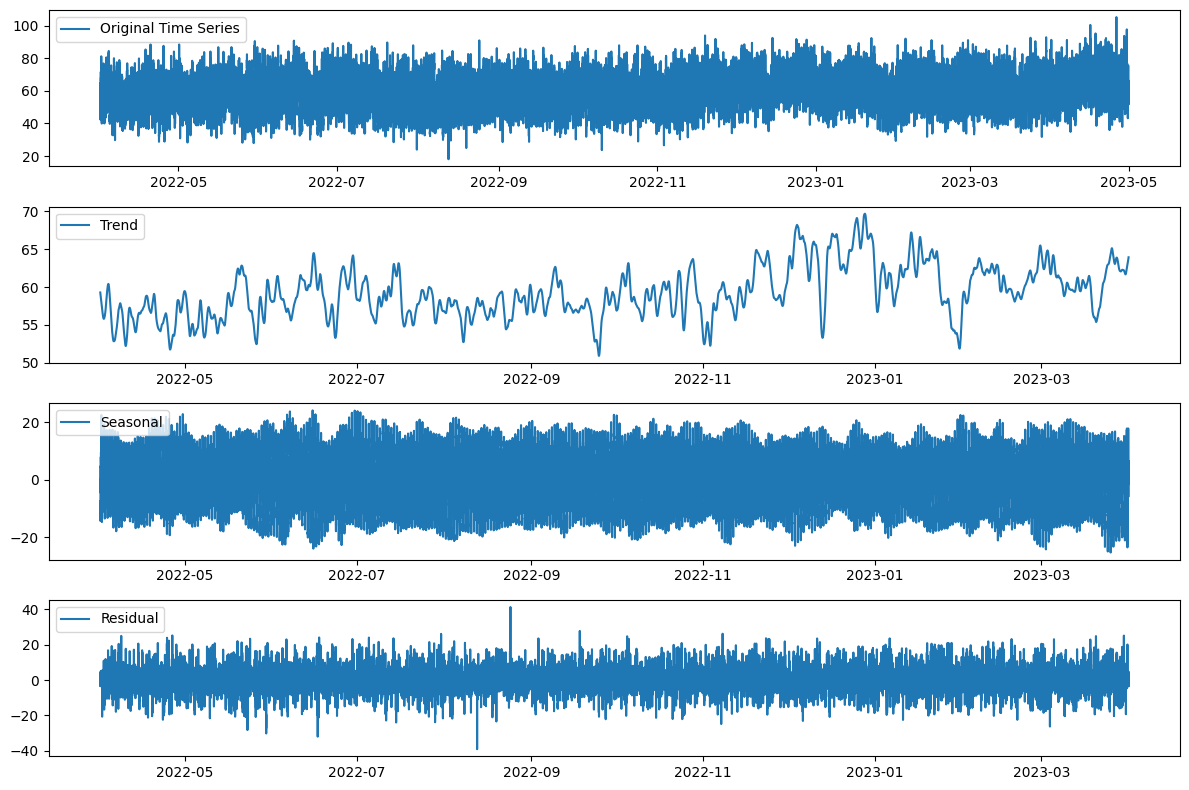

In [ ]:
stl = STL(train, period=96, robust=True)
result = stl.fit()
seasonal = result.seasonal
trend = result.trend
residual = result.resid

# Plot the decomposition results
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data, label='Original Time Series')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Compared to normal seasonal decompose, STL gave better results. As its was able to figure out local variations in the trend part which seaonal decompose could not. Seasonal decompose only gave a smooth trend.

After decomposing time series into its components, we are going to implement ARIMA on time series after a minute processing. For implementing ARIMA model, we will exclude the seasonal component from the training data as it will not be able to figure out seasonal patterns in time.

In [ ]:
seasonal_train = pd.DataFrame(result.seasonal,index=train.index)
seasonal_train.head()

,season
date_column,
2022-04-01 00:00:00,-7.542425
2022-04-01 00:15:00,-9.732583
2022-04-01 00:30:00,-14.329711
2022-04-01 00:45:00,-14.071615
2022-04-01 01:00:00,-9.015528


In [ ]:
trend.head()

date_column
2022-04-01 00:00:00    59.282821
2022-04-01 00:15:00    59.247129
2022-04-01 00:30:00    59.211447
2022-04-01 00:45:00    59.175776
2022-04-01 01:00:00    59.140118
Name: trend, dtype: float64

Here we are sexcluding out the seasonal component from our time series data.

## Removing Seasonality

In [ ]:
training = train.copy()
training.value = train.value - seasonal_train.season
training.head()

,value
date_column,
2022-04-01 00:00:00,59.322425
2022-04-01 00:15:00,55.892583
2022-04-01 00:30:00,56.749711
2022-04-01 00:45:00,58.401615
2022-04-01 01:00:00,58.685528


Now this training set does not contain the seasonal information. Checking our expectation using STL again.

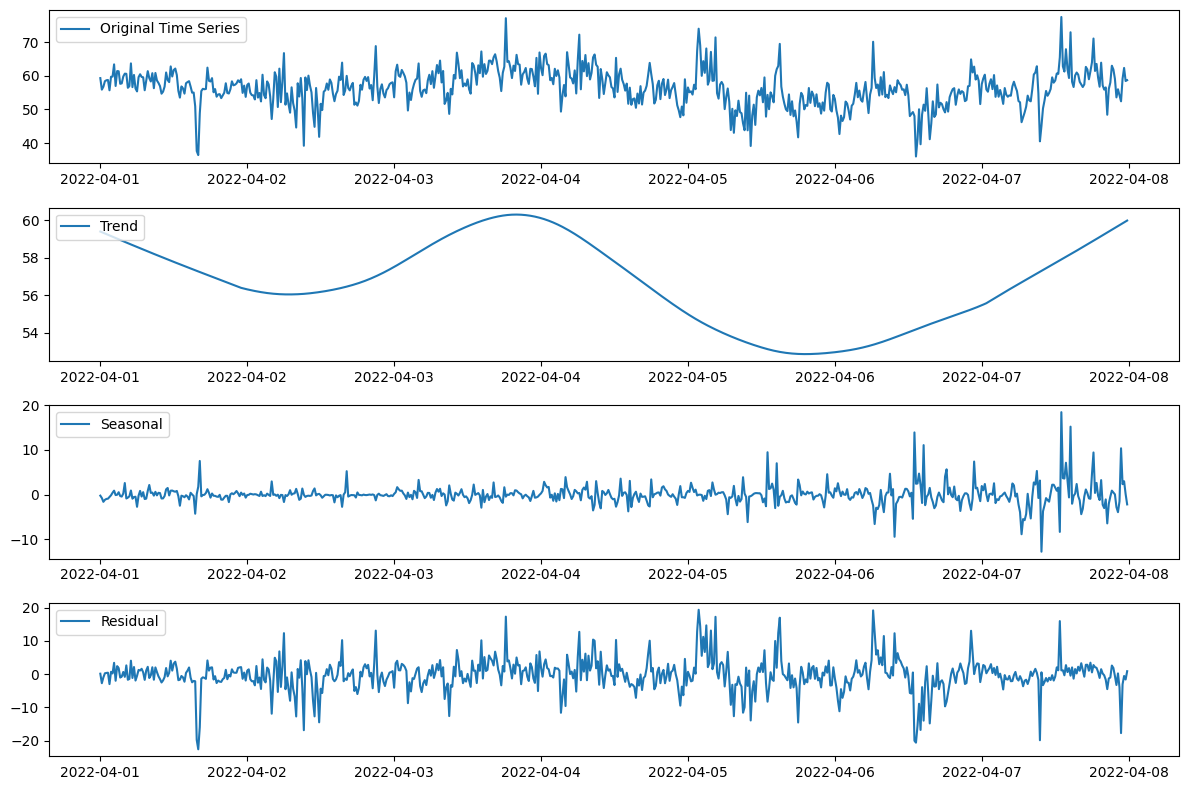

In [ ]:
subdf = training.iloc[:672]
stl = STL(subdf, period=96, robust=True)
result1 = stl.fit()
seasonal_recheck = result1.seasonal
trend_recheck = result1.trend
residual_recheck = result1.resid

# Plot the decomposition results
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(subdf, label='Original Time Series')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_recheck, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_recheck, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_recheck, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Here we can see that seasonal pattern is not periodic anymore.

## Training Arima on De-seasoned data

In [ ]:
newf, newr = arima_model(training,test,3,1,3,'15T')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                35040
Model:                 ARIMA(3, 1, 3)   Log Likelihood             -101319.395
Date:                Tue, 09 Jul 2024   AIC                         202652.789
Time:                        17:57:40   BIC                         202712.039
Sample:                    04-01-2022   HQIC                        202671.660
                         - 03-31-2023                                         
Covariance Type:                  oim                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       9.132e-05      0.025      0.004      0.997      -0.049       0.050
ar.L2          0.8471      0.016     53.806      0.000       0.816       0.878
ar.L3         -0.1323      0.015     -8.923      0.0

In [ ]:
newf = pd.DataFrame(newf,index=test.index)
newf.columns=['forecast']
newf.head()

,forecast
date_column,
2023-04-01 00:00:00,62.118932
2023-04-01 00:15:00,62.368972
2023-04-01 00:30:00,62.481147
2023-04-01 00:45:00,62.557163
2023-04-01 01:00:00,62.619122


In [ ]:
newr = pd.DataFrame(newr,index=train.index)
newr.columns=['resid']
newr.head()

,resid
date_column,
2022-04-01 00:00:00,59.322425
2022-04-01 00:15:00,-3.429324
2022-04-01 00:30:00,-0.333705
2022-04-01 00:45:00,1.271176
2022-04-01 01:00:00,0.766603


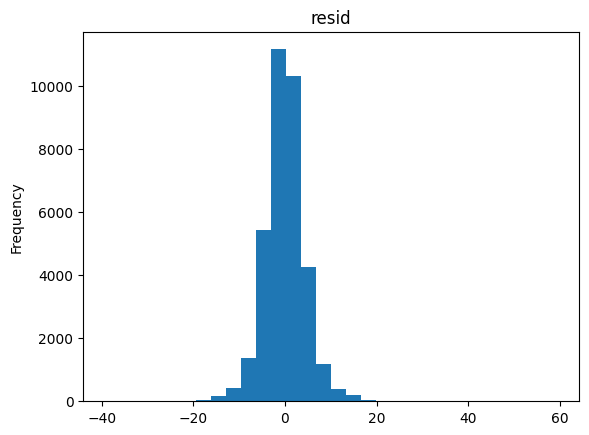

In [ ]:
newr['resid'].plot(kind='hist', bins=30, title='resid')
plt.gca().spines[['top', 'right',]].set_visible(True)

## Forecast from de-seasoned data

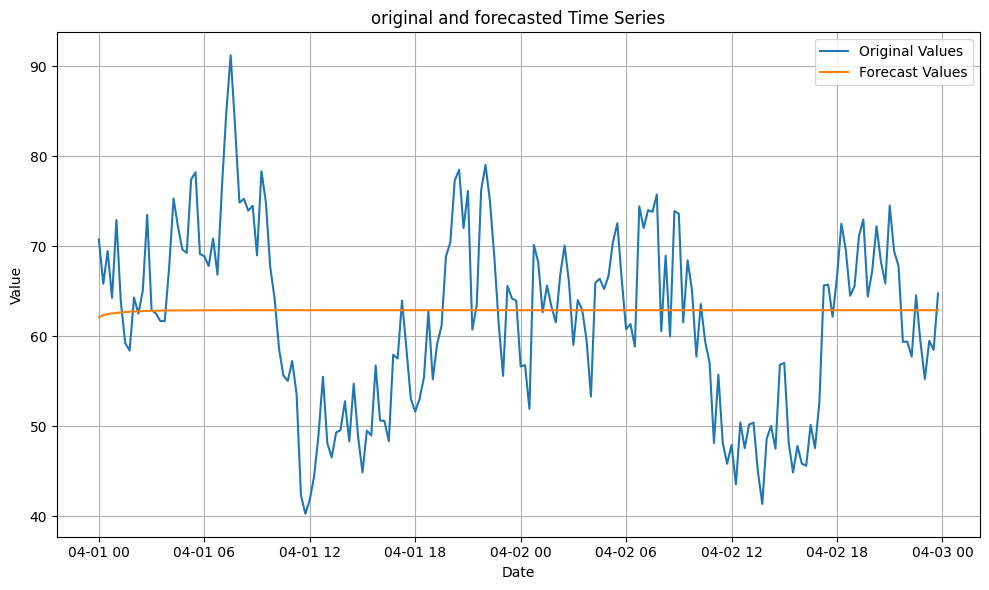

In [ ]:
plot_forecast(test.iloc[:192],newf.iloc[:192])

Ofcourse this lacks the overall seasonal pattern. So we need to put the seasonal component back into the forecasted values.

## Re-Combining Seasonal Component

We need to recombine seasonality back into the forecasted values from ARIMA to obtain the final values. Few methods that we used for obtaining appropriate seasonality values :

*   Naive Approach


    Assumption for NAIVE Approach : Perfect Seasonality is present. No influencial variations.


*   Using Avg Seasonality from Past


    For one day ahead forecasting, using the avg. values of seasonality that occured at the same time.




*   Using some model for Forecasting Seasonality


    Training SARIMA or EXPONENTIAL SMOOTHING models on seasonal data explicity to forecast seasonality values in future period.



### Naive Approach

<Axes: xlabel='date_column'>

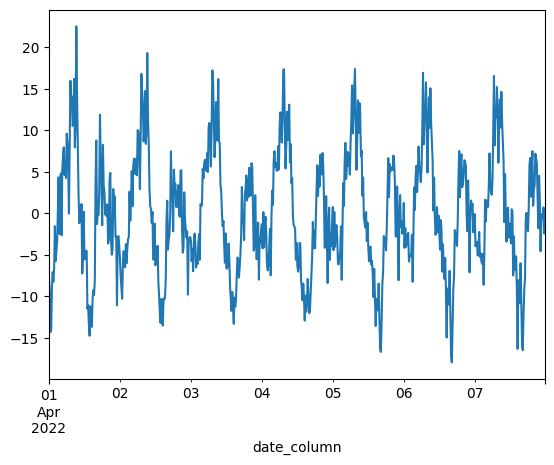

In [ ]:
seasonal_train.season.iloc[:96*7].plot()

> This is the plot that shows seasonality values for 1 week. We can clearly see that values repeat everyday. Even though these values are not completely periodic they do carry some minute variations.

> Still assuming the seasonal pattern perfectly similar for each day, we can use the last day seasonal for our day ahead forecast that we obtained through training Arima model.



In [ ]:
# Seasonal Naive Forecast
season_length = 2880
# Extract the last complete season
last_season = seasonal[-season_length:]

# Forecast the next season
seasonal_naive_forecast = np.tile(last_season.values, 1)  # Repeat the last season once
forecast_seasonal = pd.Series(seasonal_naive_forecast, index=test.index)
forecast_seasonal

date_column
2023-04-01 00:00:00    2.792563
2023-04-01 00:15:00    1.360962
2023-04-01 00:30:00   -0.537732
2023-04-01 00:45:00   -5.409391
2023-04-01 01:00:00   -8.660153
                         ...   
2023-04-30 22:45:00    1.391730
2023-04-30 23:00:00    0.154362
2023-04-30 23:15:00   -1.584247
2023-04-30 23:30:00    2.764262
2023-04-30 23:45:00    0.964140
Length: 2880, dtype: float64

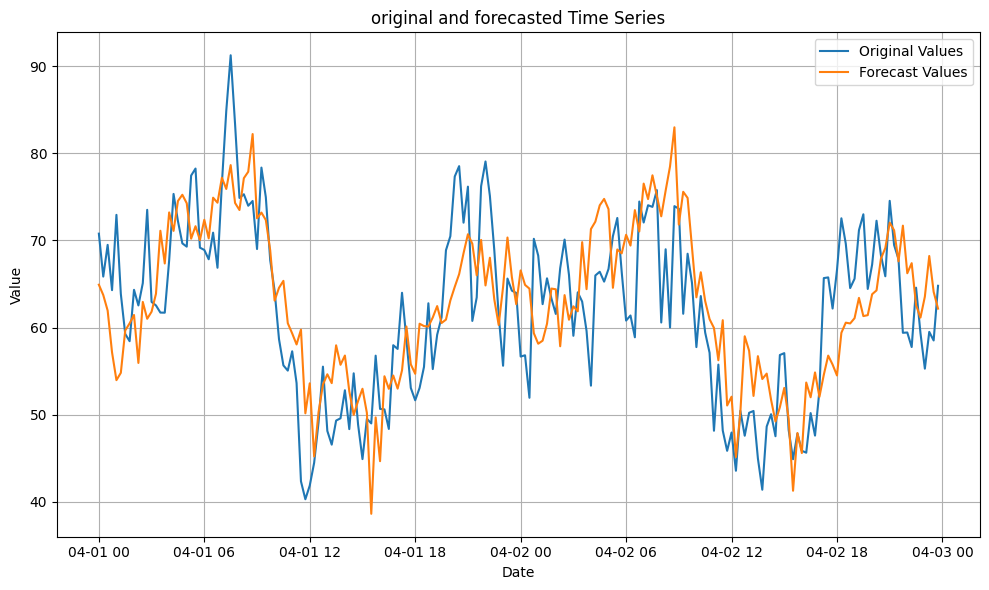

In [ ]:
final_forecast = test.copy()
final_forecast['value'] = forecast_seasonal + newf.forecast
final_forecast.rename(columns={'value':'forecast'},inplace=True)
plot_forecast(test.iloc[:192],final_forecast.iloc[:192])

In [ ]:
mape = np.mean(np.abs((test.iloc[:96].value - final_forecast.iloc[:96].forecast) / test.iloc[:96].value)) * 100
mape

8.936843422052066

In [ ]:
rmse = np.sqrt(np.mean((test.iloc[:96].value - final_forecast.iloc[:96].forecast) ** 2))
rmse

6.6268773352620975

### Averaging Past Seasonality

In [ ]:
training_seasonlaity_mean = seasonal_train.copy()
training_seasonlaity_mean['time'] = training_seasonlaity_mean.index.time
training_seasonlaity_mean.head()

,season,time
date_column,,
2022-04-01 00:00:00,-7.542425,00:00:00
2022-04-01 00:15:00,-9.732583,00:15:00
2022-04-01 00:30:00,-14.329711,00:30:00
2022-04-01 00:45:00,-14.071615,00:45:00
2022-04-01 01:00:00,-9.015528,01:00:00


In [ ]:
mean_seasonality = training_seasonlaity_mean.groupby('time').mean()
mean_seasonality

,season
time,
00:00:00,-1.158758
00:15:00,-2.160267
00:30:00,-1.831166
00:45:00,-2.382722
01:00:00,-1.056634
...,...
22:45:00,2.221696
23:00:00,0.573766
23:15:00,0.661070


In [ ]:
predicted_val = newf.copy()
predicted_val['time'] = predicted_val.index.time
predicted_val.head()

,forecast,time
date_column,,
2023-04-01 00:00:00,62.118932,00:00:00
2023-04-01 00:15:00,62.368972,00:15:00
2023-04-01 00:30:00,62.481147,00:30:00
2023-04-01 00:45:00,62.557163,00:45:00
2023-04-01 01:00:00,62.619122,01:00:00


In [ ]:
# Create a function to apply seasonality values based on 'time'
def add_seasonality(row):
    time = row['time']
    seasonality_value = mean_seasonality.loc[mean_seasonality.index == time, 'season'].iloc[0]
    return row['forecast'] + seasonality_value

# Apply the function to create 'final_forecast' column
predicted_val['forecast'] = predicted_val.apply(add_seasonality, axis=1)

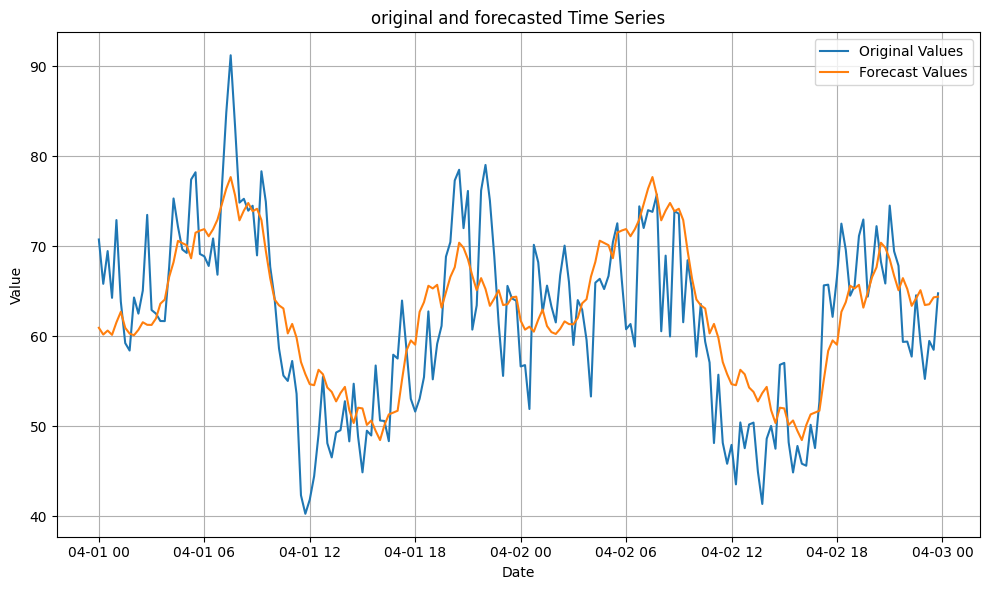

In [ ]:
plot_forecast(test.iloc[:192],predicted_val.iloc[:192])

In [ ]:
mape = np.mean(np.abs((test.iloc[:96].value - predicted_val.iloc[:96].forecast) / test.iloc[:96].value)) * 100
mape

8.396710609395917

In [ ]:
rmse = np.sqrt(np.mean((test.iloc[:96].value - predicted_val.iloc[:96].forecast) ** 2))
rmse

6.304648393489796



> Now, we can try for forecasting the seasonal values ahead int time, keeping a track of seasonality in training data. We can try for using some statistical methods such as SARIMA model for forecasting the seasonal pattern.



### Using Sarima for forecasting seasonality

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(seasonal_train.season)

Results of Dickey-Fuller Test:
Test Statistic                   -48.904905
p-value                            0.000000
Lags Used                         52.000000
Number of Observations Used    34987.000000
Critical Value (1%)               -3.430537
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='ct', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

kpss_test(seasonal_train.season)

Results of KPSS Test:
Test Statistic             0.011028
p-value                    0.100000
Lags Used                101.000000
Critical Value (10%)       0.119000
Critical Value (5%)        0.146000
Critical Value (2.5%)      0.176000
Critical Value (1%)        0.216000
dtype: float64


<ipython-input-31-d61825228046>:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='ct', nlags="auto")


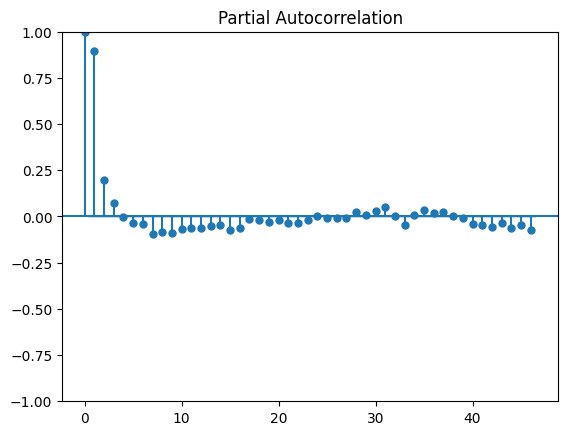

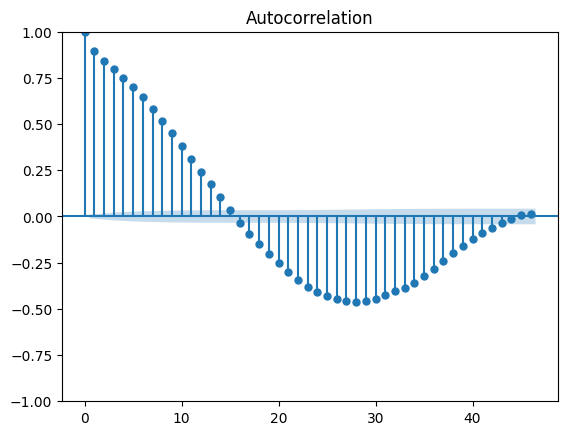

In [ ]:
plot_pacf(seasonal_train.season)
plot_acf(seasonal_train.season)
plt.show()

In [ ]:
sforecast, sresid = sarima_model(seasonal_train.season,test,1,0,1,1,0,1,48,'15T')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             season   No. Observations:                35040
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 48)   Log Likelihood              -88755.106
Date:                            Mon, 24 Jun 2024   AIC                         177520.213
Time:                                    07:53:48   BIC                         177562.534
Sample:                                04-01-2022   HQIC                        177533.692
                                     - 03-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9459      0.002    477.593      0.000       0.942       0.950
ma.L1         -0.3393      0.006   

In [ ]:
seasonal_train.rename(columns={'season':'value'},inplace=True)
sforecast = pd.DataFrame(sforecast,index=test.index)
sforecast.columns=['forecast']

In [ ]:
sforecast.head()

,forecast
date_column,
2023-04-01 00:00:00,0.574469
2023-04-01 00:15:00,1.358734
2023-04-01 00:30:00,0.966188
2023-04-01 00:45:00,-0.209719
2023-04-01 01:00:00,2.676444


For comparing forecasted seasonality with test series seasonality, decomposing the test time series.

In [ ]:
stl = STL(test, period=96, robust=True)
result2 = stl.fit()
testseason = result2.seasonal
seasonal_test = pd.DataFrame(testseason,index=test.index)
seasonal_test.columns=['value']
seasonal_test.head()

,value
date_column,
2023-04-01 00:00:00,0.046128
2023-04-01 00:15:00,-2.526830
2023-04-01 00:30:00,-0.921655
2023-04-01 00:45:00,1.823056
2023-04-01 01:00:00,8.272021


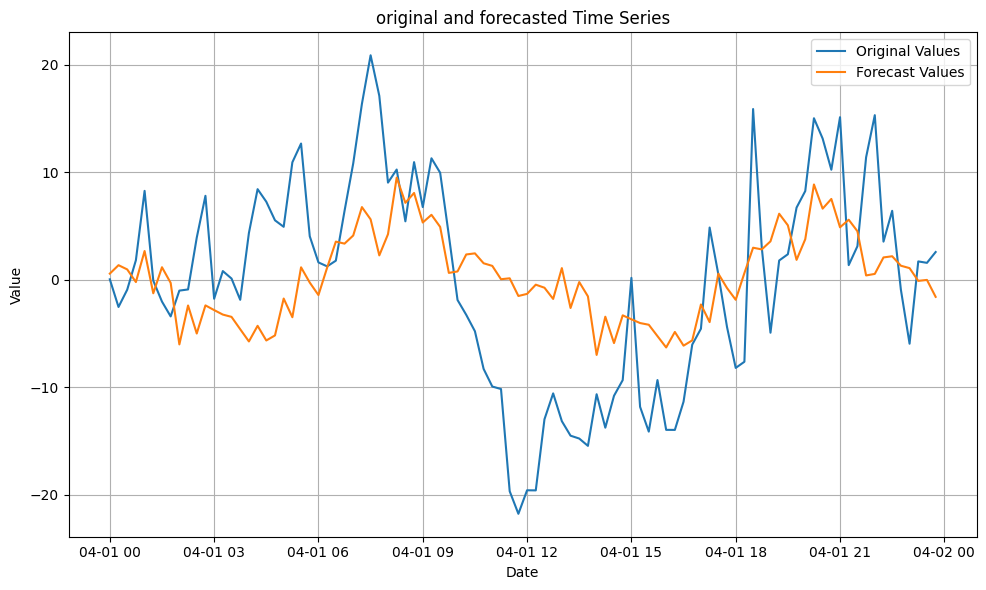

In [ ]:
plot_forecast(seasonal_test.iloc[:96],sforecast.iloc[:96])

We can see that the forecasted seasonality has aquired some pattern but not completely. Still at some parts forecast is far apart from original.

Tuning parameters might make Sarima work better.

Trying Smoothening to make it seasier for sarima to capture seasonal pattern.

### Smoothening and SARIMA

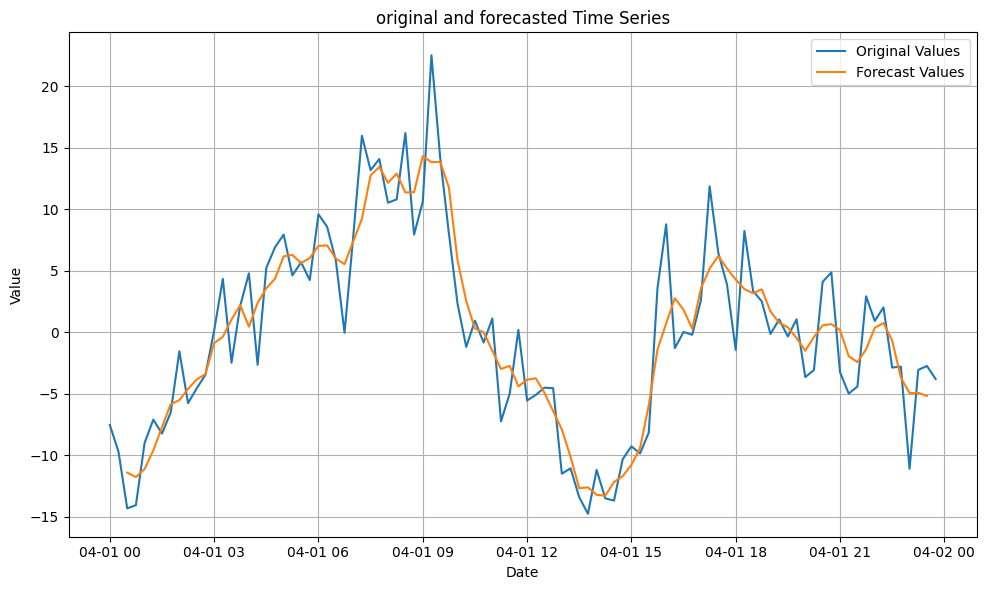

In [ ]:
window_size = 4
y_smoothed = pd.Series(seasonal[:96]).rolling(window=window_size, center=True).mean()
# plot_forecast(seasonal[:96],pd.Series(seasonal[:96]).rolling(window=window_size, center=True).mean())
temp1=seasonal[:96]
temp2=y_smoothed[:96]
plt.figure(figsize=(10, 6))
plt.plot(temp1.index, temp1, label='Original Values')
plt.plot(temp2.index, temp2, label='Forecast Values')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('original and forecasted Time Series')
plt.legend()
  # Show legend based on 'label' values

# Display the plot
plt.grid(True)  # Optional: add grid
plt.tight_layout()  # Optional: improve spacing
plt.show()

Smoothening the Training data for implementing SARIMA on it.

In [ ]:
window_size = 4
train_season_smooth = pd.Series(seasonal).rolling(window=window_size, center=True).mean()
train_season_smooth

date_column
2022-04-01 00:00:00          NaN
2022-04-01 00:15:00          NaN
2022-04-01 00:30:00   -11.419083
2022-04-01 00:45:00   -11.787359
2022-04-01 01:00:00   -11.132649
                         ...    
2023-03-31 22:45:00     2.059089
2023-03-31 23:00:00     1.632238
2023-03-31 23:15:00     0.681527
2023-03-31 23:30:00     0.574629
2023-03-31 23:45:00          NaN
Name: season, Length: 35040, dtype: float64

In [ ]:
train_season_smooth.fillna(train_season_smooth.mean(),inplace=True)
train_season_smooth

date_column
2022-04-01 00:00:00    -0.000722
2022-04-01 00:15:00    -0.000722
2022-04-01 00:30:00   -11.419083
2022-04-01 00:45:00   -11.787359
2022-04-01 01:00:00   -11.132649
                         ...    
2023-03-31 22:45:00     2.059089
2023-03-31 23:00:00     1.632238
2023-03-31 23:15:00     0.681527
2023-03-31 23:30:00     0.574629
2023-03-31 23:45:00    -0.000722
Name: season, Length: 35040, dtype: float64

Training Sarima on smoothened seasonal series.

In [ ]:
sf, sr = sarima_model(train_season_smooth,test,1,0,1,1,0,1,48,'15T')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             season   No. Observations:                35040
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 48)   Log Likelihood              -50069.806
Date:                            Mon, 24 Jun 2024   AIC                         100149.611
Time:                                    11:11:47   BIC                         100191.932
Sample:                                04-01-2022   HQIC                        100163.091
                                     - 03-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9673      0.001    700.987      0.000       0.965       0.970
ma.L1          0.5263      0.005   

In [ ]:
sf

2023-04-01 00:00:00   -0.480899
2023-04-01 00:15:00   -0.693103
2023-04-01 00:30:00   -0.734914
2023-04-01 00:45:00   -0.094527
2023-04-01 01:00:00   -0.662740
                         ...   
2023-04-01 22:45:00    1.768946
2023-04-01 23:00:00    1.201764
2023-04-01 23:15:00    0.630278
2023-04-01 23:30:00   -0.138561
2023-04-01 23:45:00   -0.894303
Freq: 15T, Name: predicted_mean, Length: 96, dtype: float64

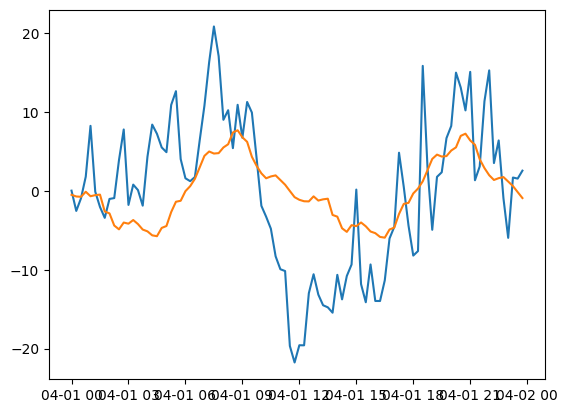

In [ ]:
plt.plot(testseason.iloc[:96])
plt.plot(sf)
plt.show()

Smoothening also could not help Sarima perform better.

In [ ]:
combined_df = test.iloc[:96].copy()
combined_df['value'] = sf + newf.forecast.iloc[:96]
combined_df.rename(columns={'value':'forecast'},inplace=True)
combined_df

,forecast
date_column,
2023-04-01 00:00:00,61.638033
2023-04-01 00:15:00,61.675868
2023-04-01 00:30:00,61.746234
2023-04-01 00:45:00,62.462636
2023-04-01 01:00:00,61.956382
...,...
2023-04-01 22:45:00,64.681875
2023-04-01 23:00:00,64.115022
2023-04-01 23:15:00,63.543210




> Forecast after the seasonality values were explicitly processed and forecasted using SARIMA model and then recombined beack to forecast from (trend+residue) of training data.



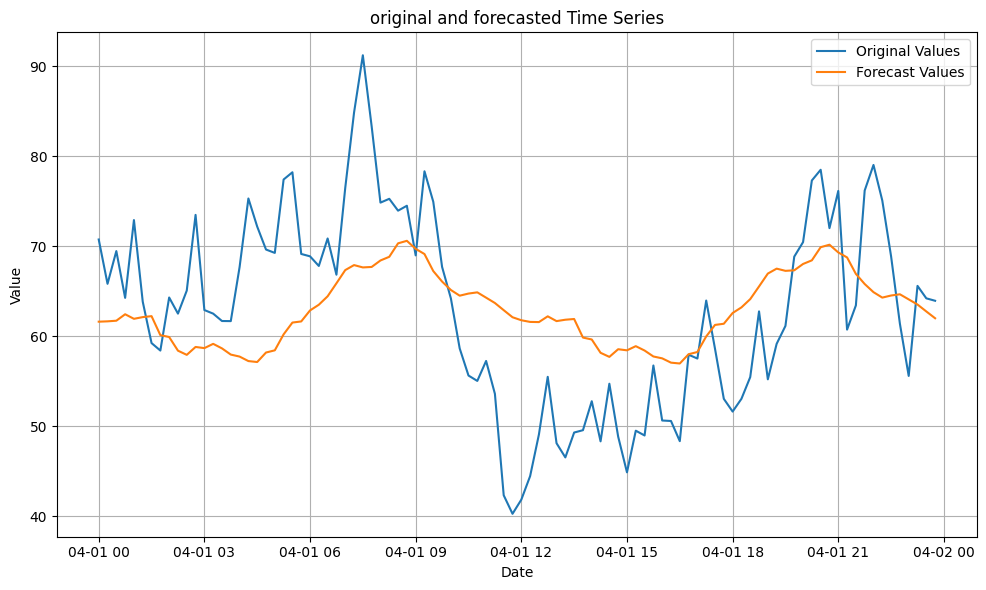

In [ ]:
plot_forecast(test.iloc[:96],combined_df.iloc[:96])

Forecast from adding seasonal values back to the forecast values obtained from ARIMA model.

### Exponential Smoothening for Seasonality Forecast

Using exponential smoothening model for forecasting the seasonal values.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train_season_smooth, seasonal='additive', seasonal_periods=96)
fit = model.fit()
sf = fit.forecast(288)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


This one was trained over train data seasonality after smoothing.

In [ ]:
combined_df = test.iloc[:192].copy()
combined_df['value'] = sf[:192] + newf.forecast.iloc[:192]
combined_df.rename(columns={'value':'forecast'},inplace=True)
combined_df

,forecast
date_column,
2023-04-01 00:00:00,64.060708
2023-04-01 00:15:00,63.418854
2023-04-01 00:30:00,62.284334
2023-04-01 00:45:00,65.868133
2023-04-01 01:00:00,64.909287
...,...
2023-04-02 22:45:00,64.964263
2023-04-02 23:00:00,64.535401
2023-04-02 23:15:00,63.586741


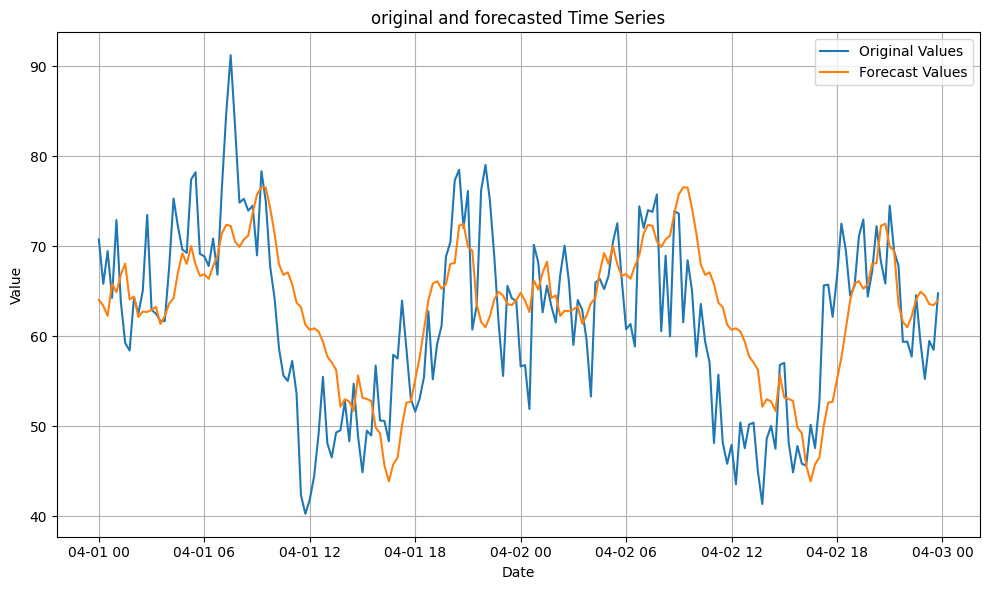

In [ ]:
plot_forecast(test.iloc[:192],combined_df)

The seasonal pattern is quite ok. But there still local variation values that needs to be fixed.


In [ ]:
mape = np.mean(np.abs((test.value - combined_df.forecast) / test.value)) * 100
mape

10.533792951066278

In [ ]:
model1 = ExponentialSmoothing(seasonal_train, seasonal='additive', seasonal_periods=96)
fit = model1.fit()

# Predict future values
sf = fit.forecast(288)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


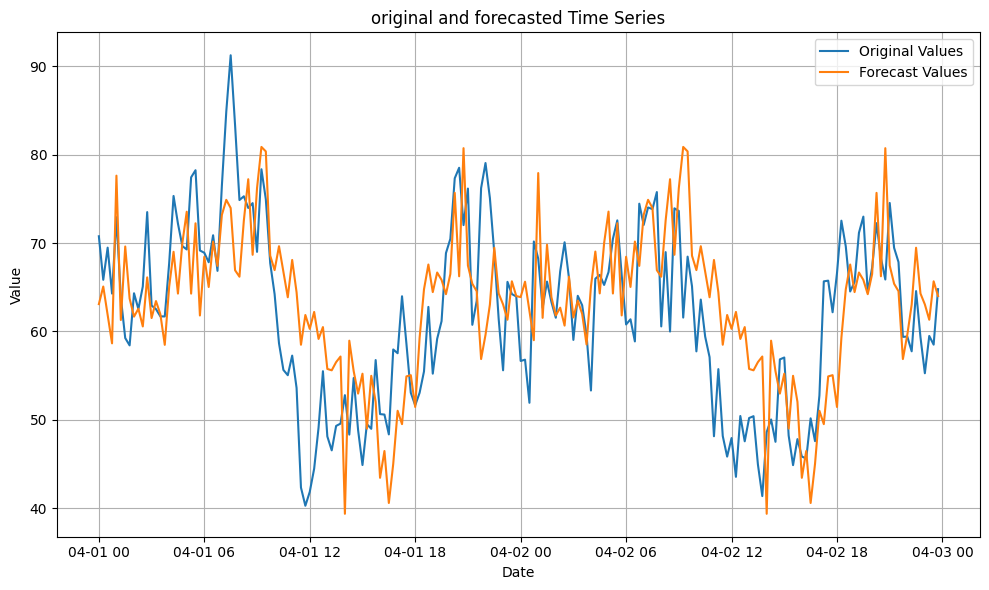

In [ ]:
combined_df = test.iloc[:192].copy()
combined_df['value'] = sf[:192] + newf.forecast.iloc[:192]
combined_df.rename(columns={'value':'forecast'},inplace=True)
plot_forecast(test.iloc[:192],combined_df)

In [ ]:
mape = np.mean(np.abs((test.iloc[:96].value - combined_df.forecast) / test.iloc[:96].value)) * 100
mape

11.252210484595148